# Wolf Classifier

## Why a wolf classifier you ask?
Because I'm fascinated by them. Unfortunately they are not suitable to keep as pets. So, I thought what's the next best thing to do?
And the answer was to make a classifier for them!

In [3]:
from fastai.vision import *

# Collecting Data
**We will be collecting data for our classifier from google images.** For more details on how to do this, check [this](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/) by Adrian Rosebrock.

We will be classifiying wolves into four categories:
1. Arctic
2. Eastern
3. Indian
4. Northwestern


In [1]:
folders = ['Arctic', 'Eastern', 'Indian', 'Northwestern']
files = ['data_files/arctic_wolf.csv', 'data_files/eastern_wolf.csv', 'data_files/indian_wolf.csv', 'data_files/northwestern_wolf.csv']

In [6]:
for i in range(len(folders)):
  path = Path('data/wolves')
  dest = path/folders[i]
  dest.mkdir(parents=True, exist_ok=True)
  links = Path(files[i])
  download_images(links, dest, max_pics=200)

In [7]:
for folder in folders:
  print(folder)
  path = Path('data/wolves')
  path = path/folder
  verify_images(path, delete=True, max_size=500)

In [9]:
np.random.seed(8)
path = Path('data/wolves')
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

So, we have downloaded our data. Let's check it out.

In [10]:
data.classes

['Arctic', 'Eastern', 'Indian', 'Northwestern']

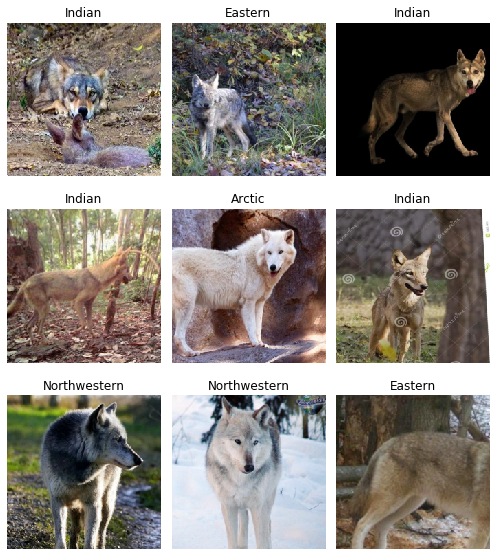

In [11]:
data.show_batch(rows=3, figsize=(7,8))

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Arctic', 'Eastern', 'Indian', 'Northwestern'], 4, 292, 73)

# Training Data
We will use ResNet34 to train our data.

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.008090,1.670294,0.452055,00:26
1,1.530075,0.963295,0.315068,00:26
2,1.207776,0.940425,0.328767,00:26
3,1.022569,0.915886,0.315068,00:27


**More than 30% error. Not looking good**

Let's save and try a few more cycles!

In [15]:
learn.save('stage-1')

In [16]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.483496,0.922170,0.328767,00:28
1,0.439175,0.965182,0.315068,00:26


In [17]:
learn.save('stage-2')

Not much change. Let's try one more time!

In [18]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.375426,1.005502,0.328767,00:26
1,0.330357,1.014720,0.328767,00:26


![Fuck, Go Back!](https://pics.me.me/fuck-go-back-%F0%9F%8C%9A%F0%9F%8C%9A%F0%9F%8C%9A-7447284.png)

**Let's load our 'stage-1' model**

In [19]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (292 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Arctic,Arctic,Arctic,Arctic,Arctic
Path: data/wolves;

Valid: LabelList (73 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Indian,Arctic,Northwestern,Northwestern,Eastern
Path: data/wolves;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

Let's unfreeze the layers and train the whole model!

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


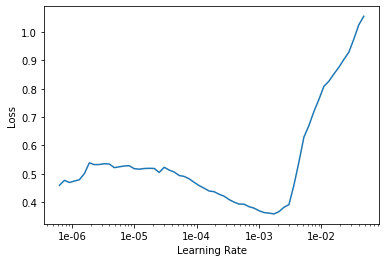

In [22]:
learn.recorder.plot()

We can see that the curve starts it fall between e-5 and e-4

In [23]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.472109,0.950462,0.342466,00:37
1,0.439325,0.998849,0.356164,00:36


In [24]:
learn.save('stage-3')

In [25]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.359217,1.012920,0.342466,00:37
1,0.326182,1.015498,0.315068,00:37


In [26]:
learn.save('stage-4')

It's better than before but only slightly!

Maybe there's some problem with out data!

Let's check it out!

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

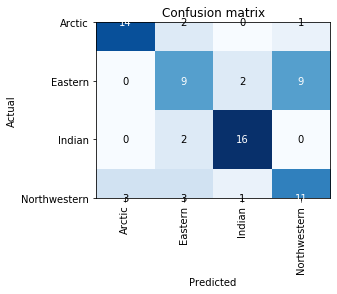

In [29]:
interp.plot_confusion_matrix()

In [31]:
from fastai.widgets import *

**We will use ImageCleaner widget to clean our data**

In [32]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [34]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (365 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Arctic,Arctic,Arctic,Arctic,Arctic
Path: data/wolves;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/wolves;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [35]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [36]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

**So, we have cleaned our data from the garbage images. There were a lot of random images!**

Let's clean load our cleaned data and train a new model on it!

# Training on cleaned data

In [40]:
path = Path('data/wolves')
cleaned_data = ImageDataBunch.from_csv(path, valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [41]:
cleaned_data.classes

['Arctic', 'Eastern', 'Indian', 'Northwestern']

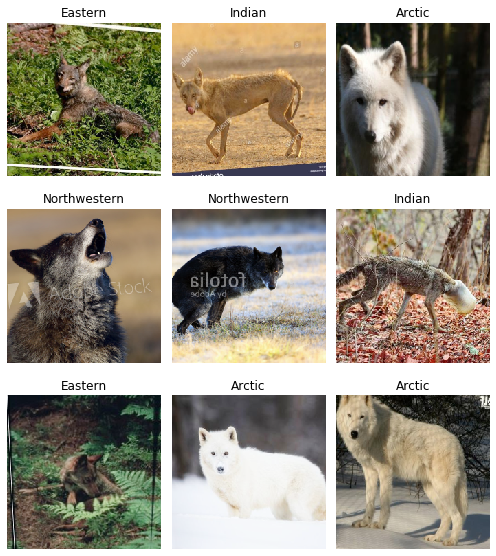

In [42]:
cleaned_data.show_batch(rows=3, figsize=(7,8))

In [43]:
cleaned_data.classes, cleaned_data.c, len(cleaned_data.train_ds), len(cleaned_data.valid_ds)

(['Arctic', 'Eastern', 'Indian', 'Northwestern'], 4, 273, 68)

In [44]:
learn_updated = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

In [45]:
learn_updated.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.206739,0.973865,0.367647,00:30
1,1.582116,0.728553,0.235294,00:29
2,1.263964,0.708561,0.191176,00:27
3,1.045564,0.674864,0.191176,00:30


In [46]:
learn_updated.save('final-1')

**Much better results this time.**

Let's see if we can improve by training all the layers!

In [47]:
learn_updated.unfreeze()

In [48]:
learn_updated.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


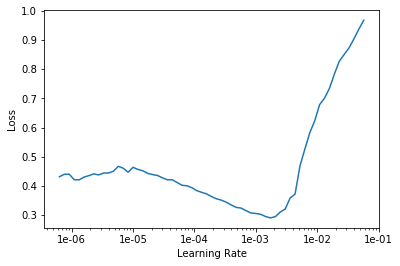

In [49]:
learn_updated.recorder.plot()

In [50]:
learn_updated.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.496629,0.577635,0.176471,00:39
1,0.416053,0.603384,0.191176,00:44


It got better first and then it reversed to original one!

Let's save and train some more!

In [51]:
learn_updated.save('final-2')

In [52]:
learn_updated.fit_one_cycle(3, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.269935,0.634112,0.235294,00:39
1,0.244362,0.726187,0.250000,00:42
2,0.218724,0.699261,0.220588,00:41


**This clearly feels like overfitting. The error rate decreased and then it started increasing**

Let's load our intial model on new data 'final-1' and train it only once because that is when we got the best accuracy.

In [53]:
learn_updated.load('final-1')
learn_updated.fit_one_cycle(1, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.488305,0.626642,0.161765,00:38


**This is the best accuracy which can be achieved for the our data.**

This is because:
1. When we trained more the data started overfitting.
2. When the data was not overfitting, our valid_loss was always less than train_loss.
3. Our training rate was also not too slow as, the model when it was not overfitting, it was constantly improving at a good pace.

**So, to improve on this model, we will need to get more data**

I think 82% will suffice for now!(There are not a lot of good images on wolves on the internet, I already got so much garbage in this data already, it was going to get worse)

In [54]:
learn_updated.save('final-3')

# Exporting and Predicting

In [56]:
learn_updated.export()

In [57]:
defaults.device = torch.device('cpu')

In [59]:
learn = load_learner('data/wolves/')

This is an image of Artic wolf which was not part of the dataset. Let's try out the classifier on it!

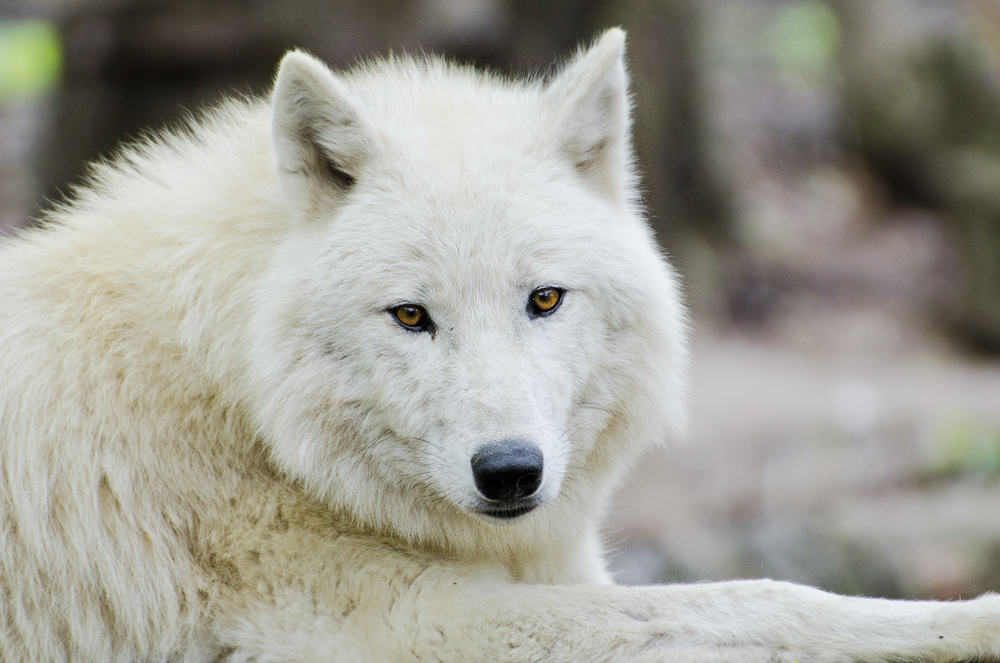

In [60]:
img = open_image('test.jpg')
img

In [61]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Arctic

**Voila**

Now all I have to do is sneek in a wolf and fool everyone into thinking that's it's a dog!